In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 126.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.4 MB/s eta 0:00:00


In [ ]:
from typing import Optional
import torch
import transformers
from transformers import AutoModelWithLMHead, PreTrainedTokenizerFast
from fastai.text.all import *
import fastai
import re

In [ ]:
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
  bos_token='</s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [ ]:
model = AutoModelWithLMHead.from_pretrained("skt/kogpt2-base-v2")

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/modeling_auto.py:1362: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


In [ ]:
import pandas as pd
import pickle

lyrics_df = pd.read_excel("/content/drive/MyDrive/1조 자연어 및 이미지/가사/melon_music_indie.xlsx")  # Adjust the filename and path to your dataset

#model input output tokenizer
class TransformersTokenizer(Transform):
   def __init__(self, tokenizer): self.tokenizer = tokenizer
   def encodes(self, x):
       toks = self.tokenizer.tokenize(x)
       return tensor(self.tokenizer.convert_tokens_to_ids(toks))
   def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))


In [ ]:
lyrics = list(lyrics_df['lyrics'])

In [ ]:
train=lyrics[:int(len(lyrics)*0.9)]
test=lyrics[int(len(lyrics)*0.9):]
splits = [[0],[1]]

In [ ]:
train = ' '.join(train)
test = ' '.join(test)

In [ ]:
#init dataloader
tls = TfmdLists([train,test], TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
batch,seq_len = 8,256
dls = tls.dataloaders(bs=batch, seq_len=seq_len)

SuggestedLRs(valley=3.0199516913853586e-05)


epoch,train_loss,valid_loss,perplexity,time
0,5.503715,5.464225,236.092880,2:32:11


epoch,train_loss,valid_loss,perplexity,time


KeyboardInterrupt: ignored

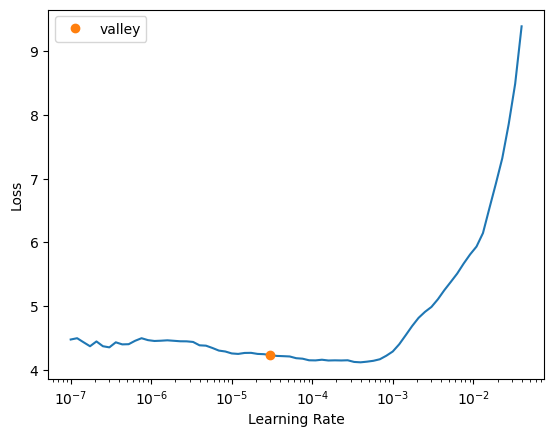

In [ ]:
#gpt2 ouput is tuple, we need just one val
class DropOutput(Callback):
  def after_pred(self): self.learn.pred = self.pred[0]


learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()
lr=learn.lr_find()
print(lr)
learn.fine_tune(6)

In [ ]:
model.save_pretrained("/content/drive/MyDrive/1조 자연어 및 이미지/codes/samplefinetuned_model")  # Adjust the output directory
tokenizer.save_pretrained("/content/drive/MyDrive/1조 자연어 및 이미지/codes/samplefinetuned_model")  # Adjust the output directory

('/content/drive/MyDrive/1조 자연어 및 이미지/codes/samplefinetuned_model/tokenizer_config.json',
 '/content/drive/MyDrive/1조 자연어 및 이미지/codes/samplefinetuned_model/special_tokens_map.json',
 '/content/drive/MyDrive/1조 자연어 및 이미지/codes/samplefinetuned_model/tokenizer.json')

In [ ]:
text = '단지 널 사랑해 이렇게 말했지'
input_ids = tokenizer.encode(text, return_tensors='pt')
gen_ids = model.generate(input_ids,
                           max_length=50,
                           repetition_penalty=2.0,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           use_cache=True)
generated = tokenizer.decode(gen_ids[0])
print(generated)

단지 널 사랑해 이렇게 말했지그런 너의 마음을내게 기대워서 난 네가 내게 닿을 수 있을까너에게 있어줘이젠 내 마음이 너무 아파도아직히 웃어봐요우리가 함께 했던 그 자리에


In [ ]:
### 아래는 문장 단위로 넣으려다 그만둔 코드입니다. 위까지만 보면 되어요!

In [ ]:
### Prepare data
lyrics = lyrics_df['lyrics']

#Drop the songs with lyrics too long
#lyric 데이터를 str로 만드는 과정 거칠 것. 혹시 모르니.
df = df[df['lyrics'].apply(lambda x: len(x.split(' ')) < 350)]

#영어를 포함한 데이터를 걸러내는 과정을 필히 추가할 것.

#Create a very small test set to compare generated text with the reality
#늘임표는 무슨 의미?
test_set = df.sample(n = 200)
df = df.loc[~df.index.isin(test_set.index)]

#Reset the indexes
test_set = test_set.reset_index()
df = df.reset_index()

#For the test set only, keep last 20 words in a new column, then remove them from original column
#20단어인데 한국어니까 조절을 좀 해야함. 데이터셋 확인.
test_set['True_end_lyrics'] = test_set['Lyric'].str.split().str[-20:].apply(' '.join)
test_set['Lyric'] = test_set['Lyric'].str.split().str[:-20].apply(' '.join)


class SongLyrics(Dataset):
    def __init__(self, control_code, truncate=False, gpt2_type="gpt2", max_length=1024):

        self.tokenizer = GPT2Tokenizer.from_pretrained(gpt2_type) #필히 수정해야... 내가 쓸 것은 kogpt2
        self.lyrics = []

        for row in df['Lyric']:
          self.lyrics.append(torch.tensor(
                self.tokenizer.encode(f"<|{control_code}|>{row[:max_length]}<|endoftext|>")
            ))
        if truncate: #truncate는 어디서 나오는 거람?
            self.lyrics = self.lyrics[:20000]
        self.lyrics_count = len(self.lyrics)

    def __len__(self):
        return self.lyrics_count

    def __getitem__(self, item):
        return self.lyrics[item]

dataset = SongLyrics(df['Lyric'], truncate=True, gpt2_type="gpt2")